# Doc2Vec Clustering

Unsupervised clustering of forum posts using the text body. A simple approach to try and find similar posts without strict classification.

References

1. [Text Normalization with spaCy and NLTK](https://towardsdatascience.com/text-normalization-with-spacy-and-nltk-1302ff430119)
2. [Text clusterization using Python and Doc2vec](https://medium.com/@ermolushka/text-clusterization-using-python-and-doc2vec-8c499668fa61)

In [237]:
import re
import math

import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

import spacy
from gensim.models import doc2vec, Doc2Vec
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [238]:
np.random.RandomState(123)
tqdm_notebook.pandas()

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'using {torch.cuda.get_device_name(0)}')
else:
    print('no GPU avaiable')

no GPU avaiable


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load Data

In [14]:
df_ori = pd.read_json('https://github.com/charlotte-zhuang/forum-recommender/blob/master/data/sitepoint.json?raw=true')
df_ori.head()

,title,category,tags,post
0,Wordpress Website speed is too slow?,CMS & WordPress,[wordpress],"[Hi,, \nI am a beginner…I’ve created an affili..."
1,Turn variable into literal string?,JavaScript,[],"[Hello ,, \nI’m having a prob putting dialog.s..."
2,PDF and SEO for any URL quotation,Social Media,[],[I need help if any quotation of URL without l...
3,How to change the lighting of an image in CSS,HTML & CSS,[],[How do I change the lighting of an image usin...
4,Computer humour,Community,[],[Gotta love a good laugh after a long day. ]


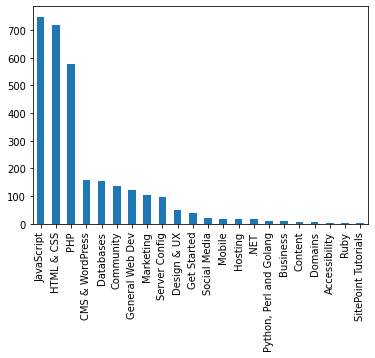

In [205]:
df_ori['category'].value_counts().plot(kind='bar')

In [207]:
df = df_ori.drop(labels=['title', 'tags'], axis=1)
df = df[df['category'].isin(['JavaScript', 'HTML & CSS', 'PHP'])]
df.shape

,category,post
1,JavaScript,"[Hello ,, \nI’m having a prob putting dialog.s..."
3,HTML & CSS,[How do I change the lighting of an image usin...
5,HTML & CSS,[I’m learning about responsive design but thin...
6,PHP,[I try to connect a server error to WP. Is it ...
9,HTML & CSS,[How to make a slider that shows people and th...


## Preprocessing

In [39]:
nlp = spacy.load('en_core_web_sm')

In [40]:
def preprocess_post(text_l: list) -> str:
    '''Converts a list of text into a single string that
        can be tokenized.
    '''
    
    text = ' '.join(text_l)
    
    # remove links
    text = re.sub(r'https?:\/\/[^\s]*', r'', text)

    # lowercase
    text = text.lower()

    # remove unwanted characters
    text = re.sub(r"[^a-z\s]+", r' ', text)
    
    # turn whitespace into a space
    text = re.sub(r'\s+', r' ', text)

    # spacy
    doc = nlp(text)

    # lemmatize
    tokens = [token.lemma_ for token in doc]

    # remove stopwords
    tokens = [word for word in tokens if not nlp.vocab[word].is_stop]

    # remove pronouns
    tokens = [word for word in tokens if word != '-PRON-']
    
    return tokens

In [208]:
prepped_posts = df['post'].apply(preprocess_post)
prepped_posts.shape

(2039,)

In [ ]:
# optionally drop data for convenience
# df = df[:1000]

## Vectorize

In [209]:
docs = [doc2vec.TaggedDocument(x, [i]) for i, x in enumerate(prepped_posts)]

In [210]:
d2v_model = Doc2Vec(docs, dm=0)
d2v_model.train(docs, total_examples=d2v_model.corpus_count, epochs=30)

## Cluster

In [222]:
kmc_model = KMeans(n_clusters=3)
pred = kmc_model.fit_predict(d2v_model.docvecs.vectors_docs)

df['cluster'] = pred
df.head()

,category,post,cluster
1,JavaScript,"[Hello ,, \nI’m having a prob putting dialog.s...",1
3,HTML & CSS,[How do I change the lighting of an image usin...,0
5,HTML & CSS,[I’m learning about responsive design but thin...,0
6,PHP,[I try to connect a server error to WP. Is it ...,2
9,HTML & CSS,[How to make a slider that shows people and th...,0


## Results

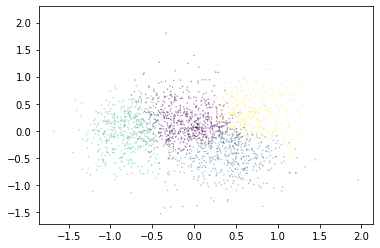

In [220]:
vis_data = PCA(n_components=2).fit_transform(d2v_model.docvecs.vectors_docs)

plt.scatter(vis_data[:,0], vis_data[:,1], c=pred, s=0.05)
plt.show()

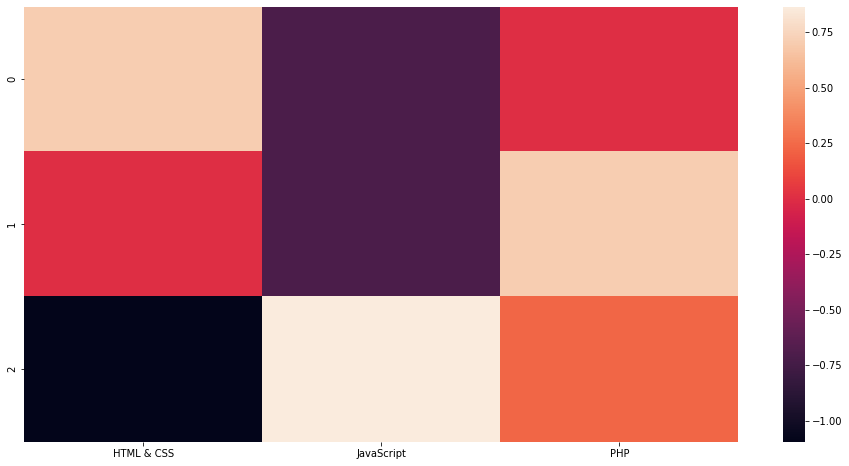

In [223]:
df_plot = df.groupby('cluster')['category'].value_counts()
df_plot = df_plot.rename('fraction').reset_index()
df_plot = df_plot[df_plot['fraction'] > 50]
df_plot['fraction'] = df_plot.groupby('cluster')['fraction'].transform(
    lambda x: (x - x.mean()) / x.std())

matrix = pd.DataFrame(
    columns=df_plot['category'].unique(), index=df_plot['cluster'].unique())
for _, row in df_plot.iterrows():
    matrix.at[row['cluster'], row['category']] = row['fraction']
matrix = matrix.fillna(0)

plt.figure(figsize=(16, 8))
sns.heatmap(matrix)

In [228]:
def predict_cluster(post):
    X = preprocess_post(post)
    vector = d2v_model.infer_vector(X)
    return kmc_model.predict([vector])[0]

In [246]:
df_rem = df_ori[~df_ori['category'].isin(['JavaScript', 'HTML & CSS', 'PHP'])]
df_rem['cluster'] = df_rem['post'].progress_apply(predict_cluster)
df_rem

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,title,category,tags,post,cluster
0,Wordpress Website speed is too slow?,CMS & WordPress,[wordpress],"[Hi,, \nI am a beginner…I’ve created an affili...",2
2,PDF and SEO for any URL quotation,Social Media,[],[I need help if any quotation of URL without l...,2
4,Computer humour,Community,[],[Gotta love a good laugh after a long day. ],0
7,How to make a custom website with HTML?,Get Started,[],"[Hi,, \nI am new here… I want to create a cuto...",2
8,What should be my requirements,Server Config,[],[Hi I need help please. What would be my serve...,2
...,...,...,...,...,...
2989,Asp form - checkbox default value,.NET,[],[Hope this is the correct category for an asp ...,1
2991,Two listings on Google Maps/Business with a si...,Marketing,[],[A single person runs a business with two very...,2
2993,Is WordPress free to use?,CMS & WordPress,[],"[Hey just curious, but is WordPress free to us...",2
2994,I Need A Website Topic (Don't mention blogs),Get Started,[],[Would anyone recommend an easy-to-code websit...,2


In [255]:
def view_examples(cluster):
    i = 0
    for _, row in df_rem[df_rem['cluster'] == cluster].iterrows():
        print(' '.join(row['post']), end='\n\n')
        if i == 4:
            break
        else:
            i += 1

In [256]:
view_examples(0)

Gotta love a good laugh after a long day.  

Hi there, I am putting together my portfolio and want to list what tools, technologies and frameworks I have used. For example: HTML, CSS, JS, Bootstrap, Grunt, SVN, WordPress etc. I am going to have some small icons with captions, but not sure what to head these up as. I thought of something like “Frameworks and Technologies Used In This Project”. I am wondering if there is a better/shorter way of saying this, maybe a proper word that would cover all these? If anyone can suggest anything else that sounds more professional, that would be great, thanks!

Hi there, I am trying to find the official JavaScript logo. I have Googled it and found that some people say there is no official logo, but have also seen the following: 
In this one, I assume the HTML5 and CSS 3 are the official ones. Does anyone know if there is one that is recognised as a JavaScript logo?

How do you copy text from one Dreamweaver document to another DW document please?  T